In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-05-08 07:05:12.618437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 07:05:12.618568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 07:05:12.761326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.Xception(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Freeze layers
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - AUC: 0.3870 - Precision: 0.6167 - Recall: 0.5333 - accuracy: 0.5694 - loss: 0.8875  

I0000 00:00:1715151942.106636     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715151942.143741     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - AUC: 0.7277 - Precision: 0.7644 - Recall: 0.6002 - accuracy: 0.6684 - loss: 0.6889

W0000 00:00:1715151949.198083     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.64931, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 244ms/step - AUC: 0.7286 - Precision: 0.7643 - Recall: 0.5999 - accuracy: 0.6684 - loss: 0.6878 - val_AUC: 0.7885 - val_Precision: 0.5885 - val_Recall: 0.9931 - val_accuracy: 0.6493 - val_loss: 1.5822
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - AUC: 0.8357 - Precision: 0.5919 - Recall: 0.7903 - accuracy: 0.6869 - loss: 0.5691
Epoch 2: val_accuracy improved from 0.64931 to 0.76389, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - AUC: 0.8344 - Precision: 0.5931 - Recall: 0.7890 - accuracy: 0.6868 - loss: 0.5699 - val_AUC: 0.8751 - val_Precision: 0.7346 - val_Recall: 0.8264 - val_accuracy: 0.7639 - val_loss: 0.4511
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - AUC: 0.8836 - Precision: 0.7737 - Recall: 0.8081 - accuracy: 0.8080 - loss: 0.4424
Epoch 3: val_accuracy did not improve from 0.76389
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/st

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy did not improve from 0.78472
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - AUC: 0.7753 - Precision: 0.6813 - Recall: 0.7003 - accuracy: 0.7262 - loss: 0.5975 - val_AUC: 0.7932 - val_Precision: 0.7647 - val_Recall: 0.6319 - val_accuracy: 0.7188 - val_loss: 0.5529
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - AUC: 0.7510 - Precision: 0.7512 - Recall: 0.6987 - accuracy: 0.7579 - loss: 0.5841
Epoch 7: val_accuracy did not improve from 0.78472
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - AUC: 0.7519 - Precision: 0.7513 - Recall: 0.6992 - accuracy: 0.7579 - loss: 0.5834 - val_AUC: 0.8590 - val_Precision: 0.7011 - val_Recall: 0.8958 - val_accuracy: 0.7569 - val_loss: 0.5085
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - AUC: 0.7314 - Precision: 0.7698 - Recall: 0.6428 - accuracy: 0.6691 - loss: 0.6400
Epoch 8: val_accuracy did not improve from 0.78472
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - AUC: 0.7327 - Precision: 0.7703 - Recall: 0.6436 - accuracy: 0.6704 - 

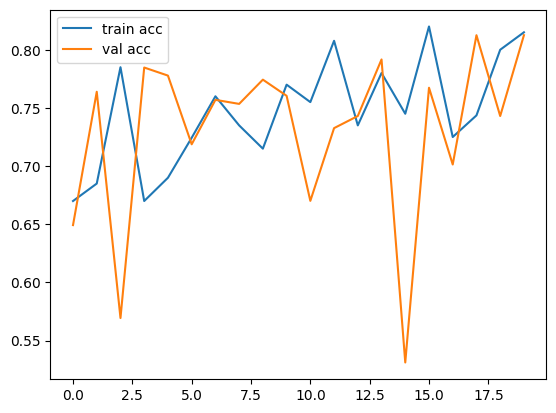

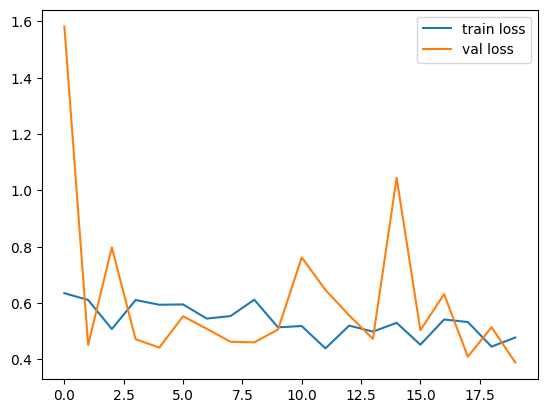

In [8]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('Xception-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('Xception-loss.png')
plt.show()

In [9]:
model.evaluate(test_generator)

106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - AUC: 0.8397 - Precision: 0.8323 - Recall: 0.7859 - accuracy: 0.7756 - loss: 0.5066


[0.5459573864936829,
 0.7654028534889221,
 0.8193976283073425,
 0.8097165822982788,
 0.7936508059501648]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.7580282]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


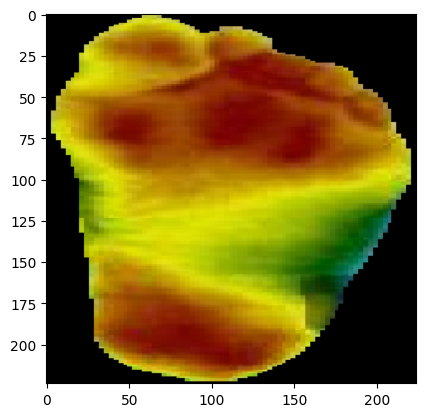

In [10]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))